In [1]:
import json
import os
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:

# List the filenames of the JSON files to be read
json_files = ['default_model.json', 'model1.json', 'model2.json']

# Initialize an empty list to store all metrics
all_metrics = []

# Loop through the filenames, read each file, and extend the all_metrics list
for file_name in json_files:
    with open(file_name, 'r') as file:
        # Load the JSON data from the file
        metrics_data = json.load(file)
        all_metrics.extend(metrics_data['metrics'])  # Assuming each file has a 'metrics' key


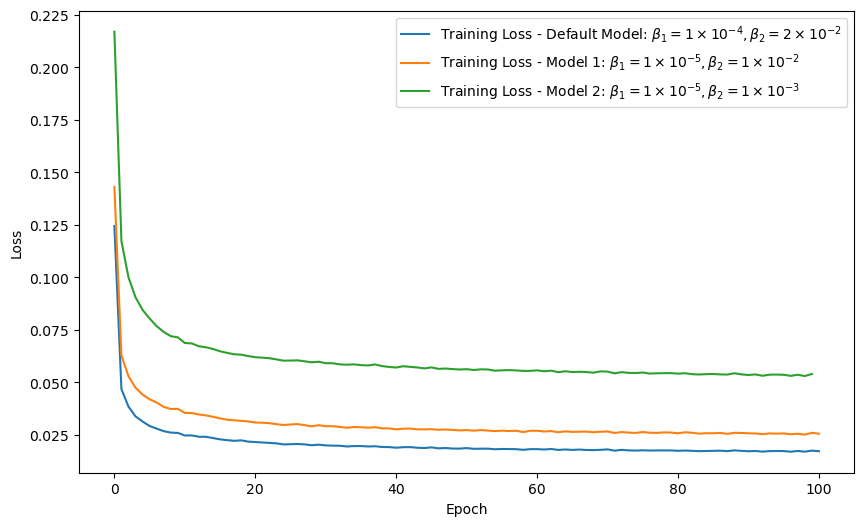

In [3]:
json_files = ['default_model.json', 'model1.json', 'model2.json']
beta_values = [1.0, 0.5, 2.0]  # Replace with your actual beta values
model_names = [
    r'Default Model: $\beta_1=1\times10^{-4}, \beta_2=2\times10^{-2}$',
    r'Model 1: $\beta_1=1\times10^{-5}, \beta_2=1\times10^{-2}$',
    r'Model 2: $\beta_1=1\times10^{-5}, \beta_2=1\times10^{-3}$'
]

# Initialize a dictionary to store the metrics for each model
models_metrics = {}

# Read each JSON file and store the metrics in the dictionary
for file_name, model_name in zip(json_files, model_names):
    with open(file_name, 'r') as file:
        # Load the JSON data from the file
        metrics_data = json.load(file)
        models_metrics[model_name] = metrics_data['metrics']

# Plot training loss for each model
plt.figure(figsize=(10, 6))
for model_name, metrics in models_metrics.items():
    epochs = [m['epoch'] for m in metrics]
    train_losses = [m['train_loss'] for m in metrics]
    plt.plot(epochs, train_losses, label=f'Training Loss - {model_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

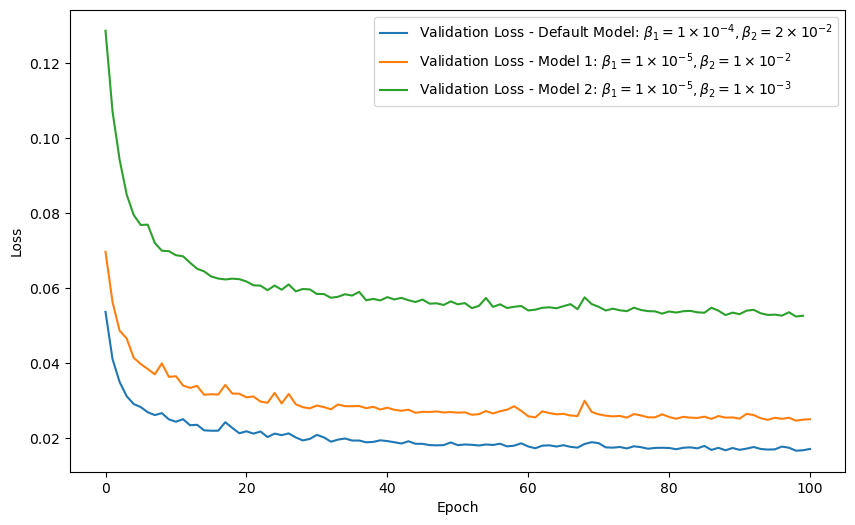

In [4]:
# Plot validation loss for each model
plt.figure(figsize=(10, 6))
for model_name, metrics in models_metrics.items():
    epochs = [m['epoch'] for m in metrics]
    val_losses = [m['val_loss'] for m in metrics]
    plt.plot(epochs, val_losses, label=f'Validation Loss - {model_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


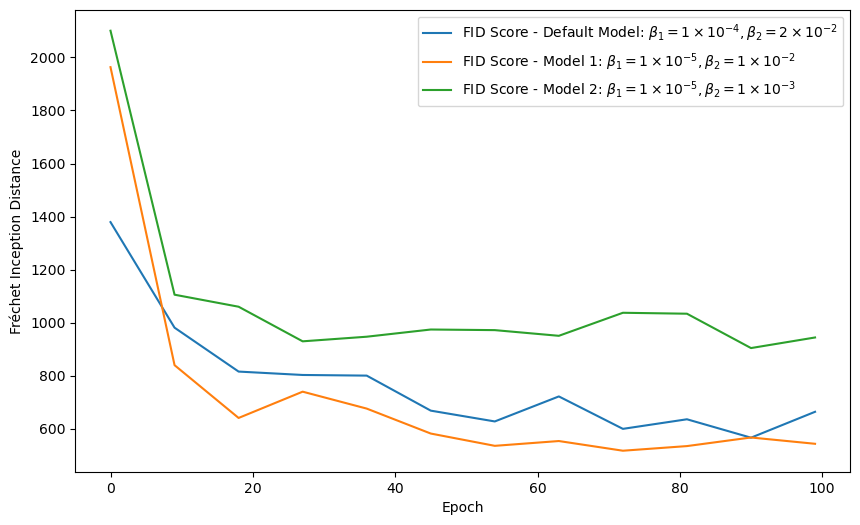

In [5]:
# Plot FID scores for each model
plt.figure(figsize=(10, 6))
for model_name, metrics in models_metrics.items():
    fid_scores = [m['fid_score'] for m in metrics if 'fid_score' in m]
    fid_epochs = [m['epoch'] for m in metrics if 'fid_score' in m]
    if fid_scores:
        plt.plot(fid_epochs, fid_scores, label=f'FID Score - {model_name}')
plt.xlabel('Epoch')
plt.ylabel('Fréchet Inception Distance')
plt.legend()
plt.show()


In [6]:
import torch
import numpy as np
from typing import Dict
import matplotlib.pyplot as plt

def ddpm_schedules(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """Returns pre-computed schedules for DDPM sampling with a linear noise schedule."""
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    alpha_t = torch.exp(torch.cumsum(torch.log(1 - beta_t), dim=0))  # Cumprod in log-space (better precision)

    return {"beta_t": beta_t, "alpha_t": alpha_t}

In [9]:

# default model
T = 1000
ts = np.linspace(0, T, T +1)
beta1, beta2 = 1e-4, 0.02
T1 = 1840
ts1 = np.linspace(0, T1, T1 +1)
beta1m1, beta2m1 = 1e-5, 0.01
T2 = 18300
ts2 = np.linspace(0, T2, T2 +1)
beta1m2, beta2m2 = 1e-5, 0.001

beta_t_dm, alpha_t_dm = ddpm_schedules(beta1, beta2, T).values()
beta_t_m1, alpha_t_m1 = ddpm_schedules(beta1m1, beta2m1, T1).values()
beta_t_m2, alpha_t_m2 = ddpm_schedules(beta1m2, beta2m2, T2).values()
beta1_t_m2, alpha1_t_m2 = ddpm_schedules(beta1m2, beta2m2, T).values()



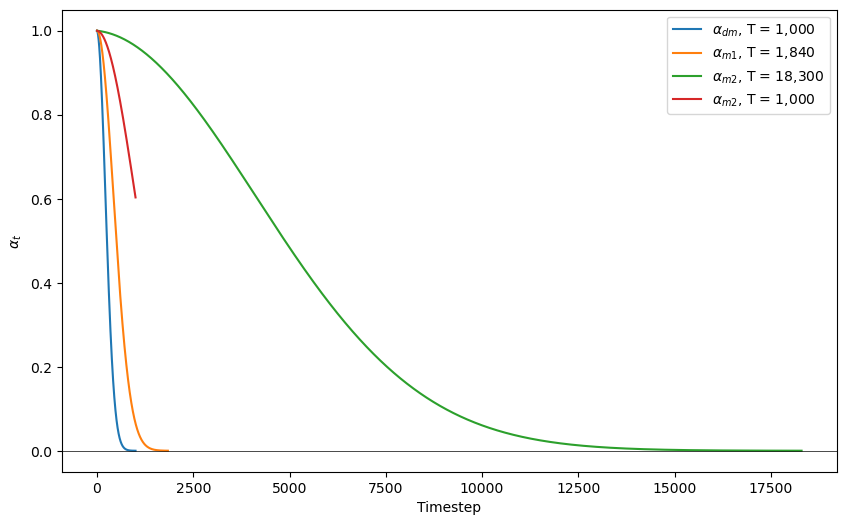

In [14]:
# plot

plt.figure(figsize=(10, 6))
plt.plot(ts, alpha_t_dm, label=r'$\alpha_{dm}$, T = 1,000')
plt.plot(ts1, alpha_t_m1, label=r'$\alpha_{m1}$, T = 1,840')
plt.plot(ts2, alpha_t_m2, label=r'$\alpha_{m2}$, T = 18,300')
plt.plot(ts, alpha1_t_m2, label=r'$\alpha_{m2}$, T = 1,000')
plt.xlabel('Timestep')
plt.ylabel(r'$\alpha_t$')
plt.legend()
# line at y = 0
plt.axhline(1e-5, color='black', linewidth=0.5)


In [78]:
alpha_t_dm

tensor([0.9999, 0.9998, 0.9997,  ..., 0.0000, 0.0000, 0.0000])

In [79]:
# check what value alpha passed theshold
tau=4e-5
alpha_t_m1
len(alpha_t_m1[alpha_t_m1 < tau])

9505

In [80]:
alpha_t_dm
for i in range(len(alpha_t_dm)):
    if alpha_t_dm[i] < tau:
        print(i)
        break

3829


In [81]:
alpha_t_m1
for i in range(len(alpha_t_m1)):
    if alpha_t_m1[i] < tau:
        print(i)
        break

5496


In [82]:
alpha_t_m2
for i in range(len(alpha_t_m2)):
    if alpha_t_m2[i] < tau:
        print(i)
        break

In [ ]:
'''
hyperparameters:
  seed: 12042000
  batch_size: 128
  num_workers: 8
  epochs: 100
  timesteps: [0, 6300, 10300, 13300, 16300, 17300, 18000, 18200, 18299, 18300]
  interval: 9

CNN:
  in_channels: 1  
  expected_shape: [28, 28]
  n_hidden: [16, 32, 32, 16] 
  kernel_size: 7  
  last_kernel_size: 3  
  time_embeddings: 16  

ddpm:
  beta1: 1e-5
  beta2: 0.001
  n_T: 18300

optim:
  lr: 2e-4

'''